<a href="https://colab.research.google.com/github/patricio-tech/proyectos/blob/master/BHcnn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Belo Horizonte
Redes neuronales convolucionales

Edwin Solís

2020

## RED NEURONAL CONVOLUCIONAL

1. Carga de datos de 1 año **[Potencia Activa]**

In [ ]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras.backend as K

In [ ]:

url = 'https://raw.githubusercontent.com/esoliss/AMI/master/Dataset/belohorizonte2017.csv'
df = pd.read_csv(url, error_bad_lines=False)
df = df.drop(columns=['Timestamp','kVARh rec int','kWh rec int','kVAR sd rec'])
df = df.drop(df.columns[-1],axis=1)
df = df.rename(columns={"kVAR sd del": "Q", "kVARh del int": "kVARh","kW sd del": "P","kWh del int": "kWh","kVA sd del": "S"})
df['Local Time'] = df['Local Time'].astype('datetime64[ns]')
var = list(df.columns)
va = {'Potencia Activa':var[3], 'Potencia Reactiva':var[1], 'Potencia Aparente': var[8], 'Voltaje An':var[5],
      'Voltaje Bn':var[6], 'Voltaje Cn':var[7], 'Corriente A':var[9], 'Corriente B':var[10], 'Corriente C':var[11],
      'Energía Activa':var[4], 'Energía Reactiva':var[3]}

# SELECCIONAR VARIABLE
select = 'Potencia Activa' 
## Opciones:
#'Potencia Activa', 'Potencia Reactiva', 'Potencia Aparente', 'Voltaje An', 'Voltaje bn', 'Voltaje Cn'
#'Corriente A', 'Corriente B', 'Corriente C', 'Energía Activa', 'Energía Reactiva'

dfil = df[['Local Time',va[select]]].copy()
n=0
for g in dfil[va[select]]:
    if g>2160:
        dfil[va[select]][n]=dfil.describe()[va[select]]['mean']
    if g<500:
        dfil[va[select]][n]=dfil.describe()[va[select]]['mean']-350
    n+=1
# SELECIONAR FECHAS
mes_inicio = 1
dia_inicio = 1
mes_final = 2
dia_final = 1

ini=datetime.datetime(2017,mes_inicio,dia_inicio,0,0)
if mes_inicio ==12:
    yf = 2018
else:
    yf =2017
fin=datetime.datetime(yf,mes_final,dia_final,0,0)
mask = (dfil["Local Time"]>=ini) & (dfil["Local Time"]<fin)
seq = dfil.loc[mask] 
dfil = seq

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2. Definición de funciones para el modelo

In [ ]:
# definición de métrica para precisión
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# creación del modelo
def crear_modeloFF():
    model = Sequential() 
    #model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Conv1D(filters=26, kernel_size=3, activation='relu', input_shape=(PASOS,1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=[soft_acc])
    model.summary()
    return model
# Resultados
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[1]-1):
        x_test[0][i][0] = x_test[0][i+1][0]
    x_test[0][x_test.shape[1]-1][0]=nuevoValor
    return x_test


3. Conversión de serie de tiempo

In [ ]:
PASOS=96
EPOCHS=200
# load dataset
values = dfil['P'].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled,PASOS,1)
# split into train and test sets
values = reframed.values
n_train_days = int(dfil.shape[0] - (dfil.shape[0]*0.2+PASOS))
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1],1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1],1))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(2284, 96, 1) (2284,) (595, 96, 1) (595,)


4. Entrenamiento del modelo

In [ ]:

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

results=model.predict(x_val)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 94, 26)            104       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 47, 26)            0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1222)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 50)                61150     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 51        
Total params: 61,305
Trainable params: 61,305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
24/24 [==============================] - 0s 13ms/step - loss: 0.1521 - soft_acc: 0.8570 - val_loss: 0.1

5. Comparativa y validación de datos

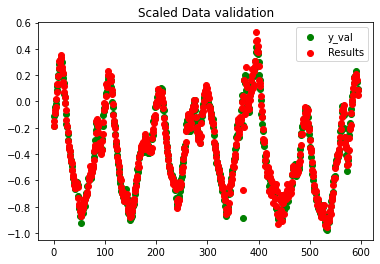

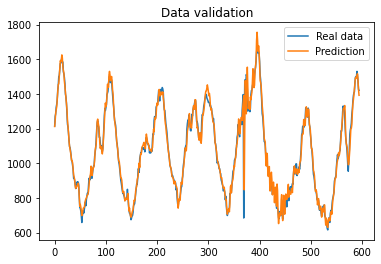

In [ ]:
plt.scatter(range(len(y_val)),y_val,c='g',label='y_val')
plt.scatter(range(len(results)),results,c='r',label='Results')
plt.title('Scaled Data validation')
if len(y_val)>2000:
  plt.xlim(2000, 3000)
plt.legend()
plt.show()

acc      = history.history[     'soft_acc' ]
val_acc  = history.history[ 'val_soft_acc' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(1,len(acc)+1,1)

compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']

compara2['real'].plot(label='Real data' )
compara2['prediccion'].plot(label='Prediction' )
plt.title('Data validation')
if len(y_val)>2000:
  plt.xlim(2000, 3000)
plt.legend()
plt.show()

6. Métricas del modelo

<Figure size 432x288 with 0 Axes>

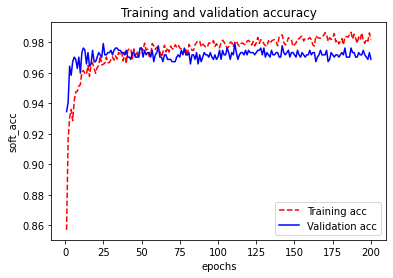

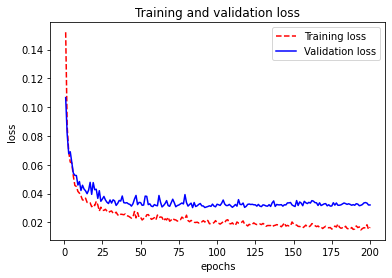

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('soft_acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--', label='Training loss' )
plt.plot ( epochs, val_loss ,  'b', label='Validation loss' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()

7. Predicción de un día completo **[Febrero]**

In [ ]:
# SELECIONAR FECHAS
mes_inicio = 1
dia_inicio = 30
mes_final = 2
dia_final = 1
dfil = df[['Local Time',va[select]]].copy()
n=0
for g in dfil[va[select]]:
    if g>2160:
        dfil[va[select]][n]=dfil.describe()[va[select]]['mean']
    if g<500:
        dfil[va[select]][n]=dfil.describe()[va[select]]['mean']-350
    n+=1
ini=datetime.datetime(2017,mes_inicio,dia_inicio,0,0)
if mes_inicio ==12:
    yf = 2018
else:
    yf =2017
fin=datetime.datetime(yf,mes_final,dia_final,0,0)
mask = (dfil["Local Time"]>=ini) & (dfil["Local Time"]<fin)
seq = dfil.loc[mask] 
dfd = seq
values = dfd['P'].values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1)
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[96]], axis=1, inplace=True)
values = reframed.values
x_test = values[95:, :]
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1],1))
print(x_test.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


(1, 96, 1)


In [ ]:
results=[]
for i in range(96):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    #print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

# SELECIONAR FECHAS
mes_inicio = 2
dia_inicio = 1
mes_final = 2
dia_final = 2

dfil = df[['Local Time',va[select]]].copy()
n=0
for g in dfil[va[select]]:
    if g>2160:
        dfil[va[select]][n]=dfil.describe()[va[select]]['mean']
    if g<500:
        dfil[va[select]][n]=dfil.describe()[va[select]]['mean']-350
    n+=1
ini=datetime.datetime(2017,mes_inicio,dia_inicio,0,0)
if mes_inicio ==12:
    yf = 2018
else:
    yf =2017
fin=datetime.datetime(yf,mes_final,dia_final,0,0)
mask = (dfil["Local Time"]>=ini) & (dfil["Local Time"]<fin)
seq = dfil.loc[mask] 
dfd = seq
values = dfd['P'].values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1)
y_val = scaler.fit_transform(values)
compara = pd.DataFrame(np.array([y_val[:,0], [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']
inverted = scaler.inverse_transform(compara.values)
compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


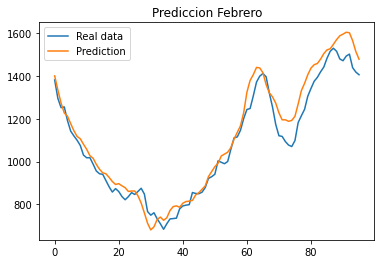

In [ ]:
compara2['real'].plot(label='Real data' )
compara2['prediccion'].plot(label='Prediction' )
plt.title('Prediccion Febrero')
plt.legend()
plt.show()